In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
from bart_playground import *

In [3]:
notebook = "real2_WineQuality"

In [4]:
import numpy as np

from ucimlrepo import fetch_ucirepo 

winequality = fetch_ucirepo(id=186) 
  
# data (as pandas dataframes) 
X = winequality.data.features
y = winequality.data.targets

In [5]:
X = X.values.astype(float)
y = np.array(y).astype(np.float32).reshape(-1)

In [6]:
ndpost = 10000
nskip = 0
n_trees = 100

In [ ]:
from experiment import run_parallel_experiments

# Run 5 parallel experiments with different train-test splits
results = run_parallel_experiments(X, y, ndpost, nskip, n_trees, notebook, n_runs=5, n_jobs=-2)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 95 concurrent workers.
Iterations: 100%|██████████| 10000/10000 [19:45<00:00,  8.44it/s]
[Parallel(n_jobs=-2)]: Done   2 out of   5 | elapsed: 23.5min remaining: 35.2min
[Parallel(n_jobs=-2)]: Done   3 out of   5 | elapsed: 23.5min remaining: 15.7min
[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed: 23.5min finished


## Default
### KPSS test

In [7]:
from diagnosis import segmented_kpss_test

=== Default BART Analysis ===

--- Run 0 ---
Sigma convergence analysis:


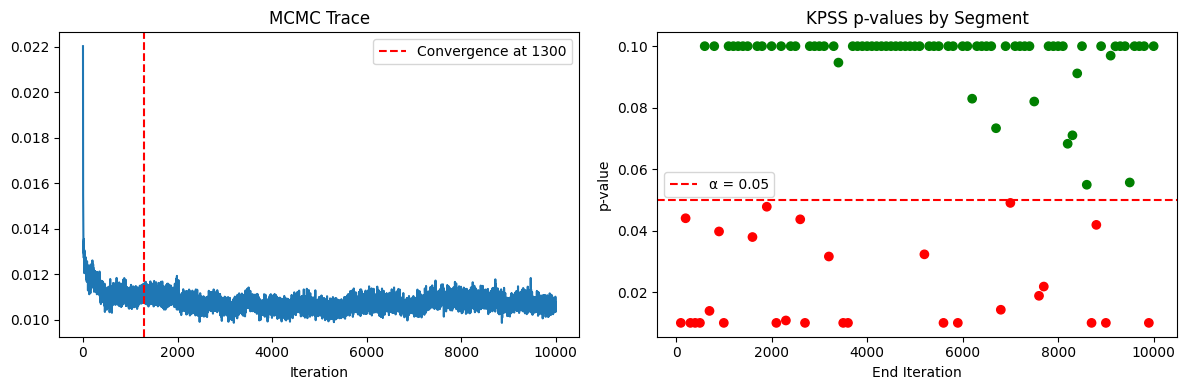

Chain converged: True
Convergence at iteration: 1300
Convergence rate: 72.00%

RMSE convergence analysis:


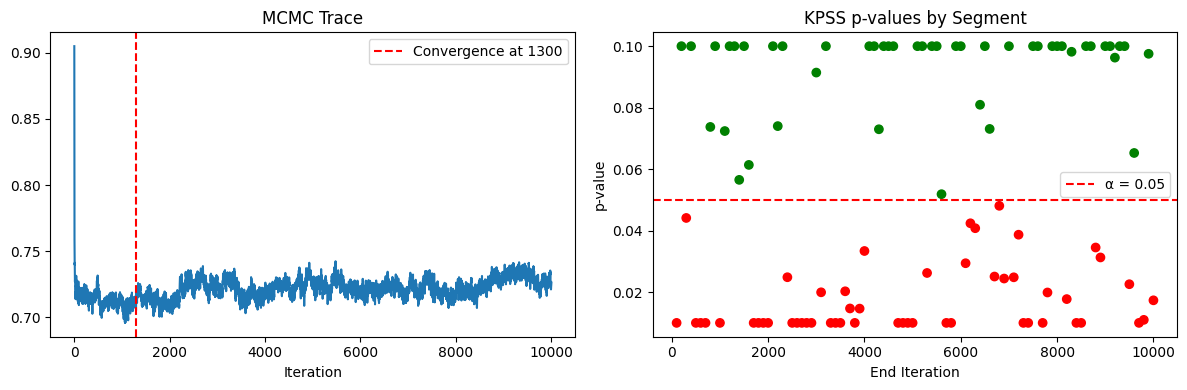

Chain converged: True
Convergence at iteration: 1300
Convergence rate: 47.00%

--- Run 1 ---
Sigma convergence analysis:


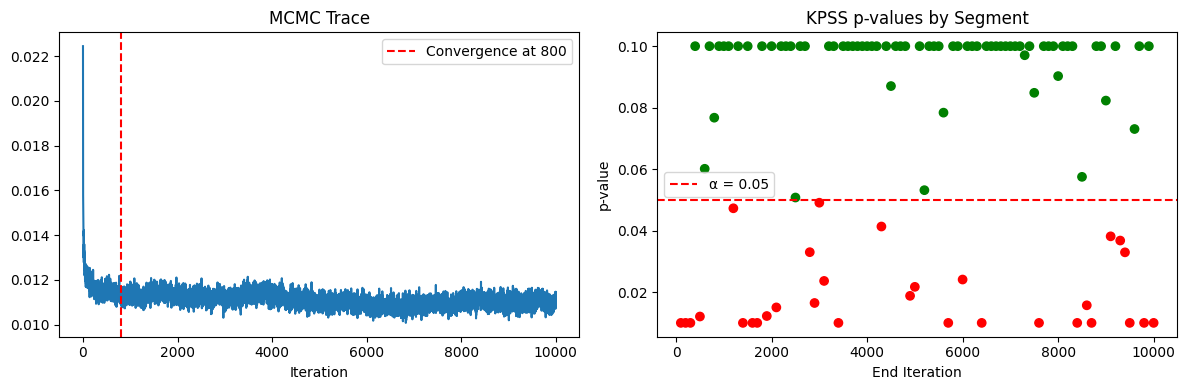

Chain converged: True
Convergence at iteration: 800
Convergence rate: 69.00%

RMSE convergence analysis:


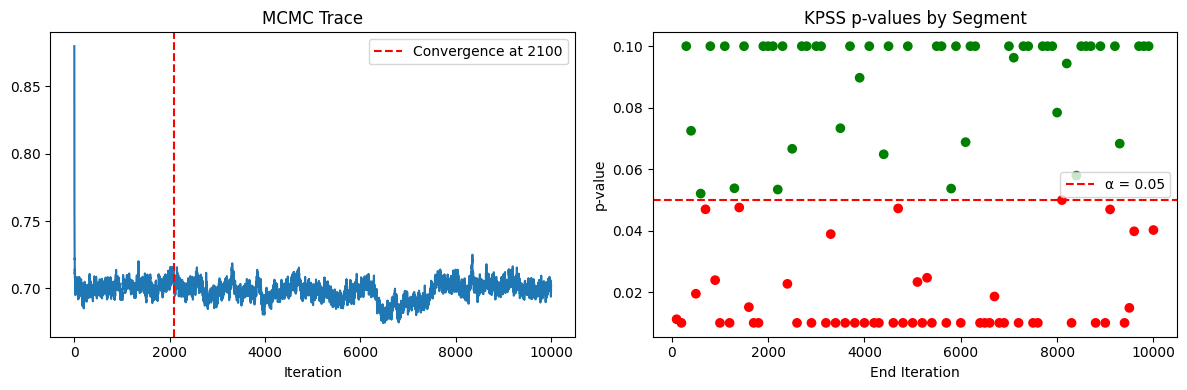

Chain converged: True
Convergence at iteration: 2100
Convergence rate: 50.00%

--- Run 2 ---
Sigma convergence analysis:


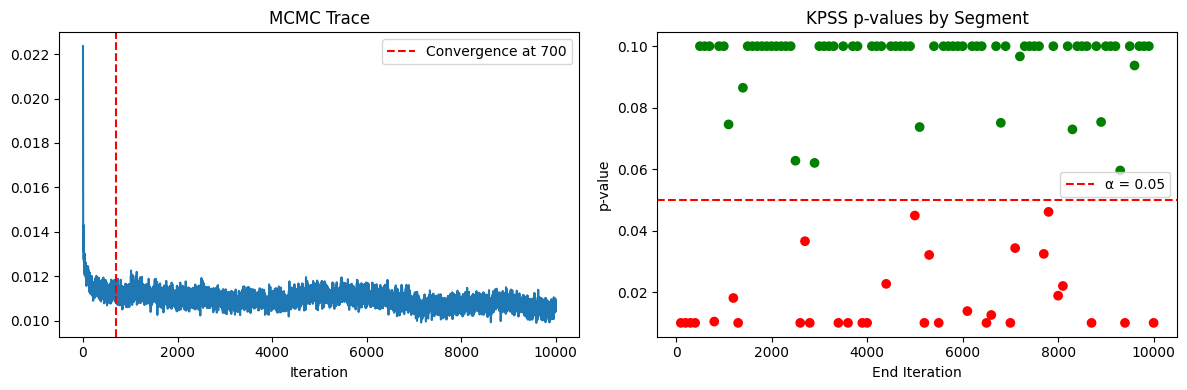

Chain converged: True
Convergence at iteration: 700
Convergence rate: 69.00%

RMSE convergence analysis:


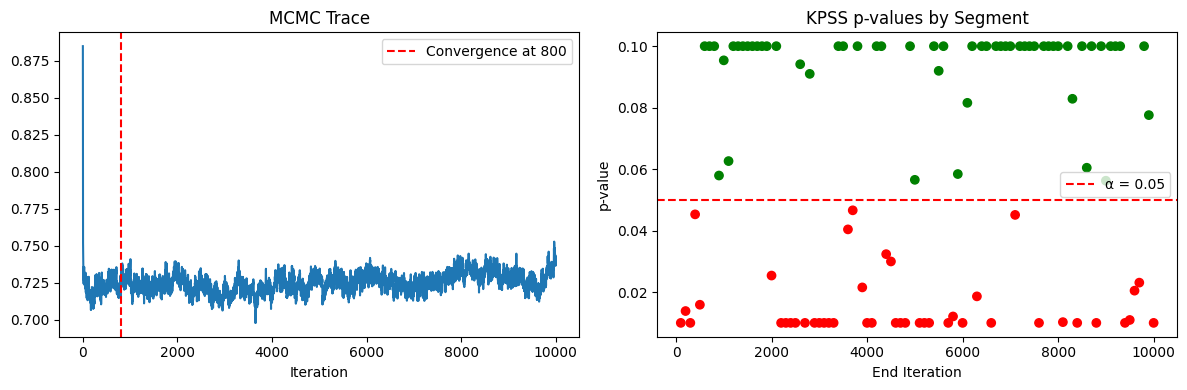

Chain converged: True
Convergence at iteration: 800
Convergence rate: 56.00%

--- Run 3 ---
Sigma convergence analysis:


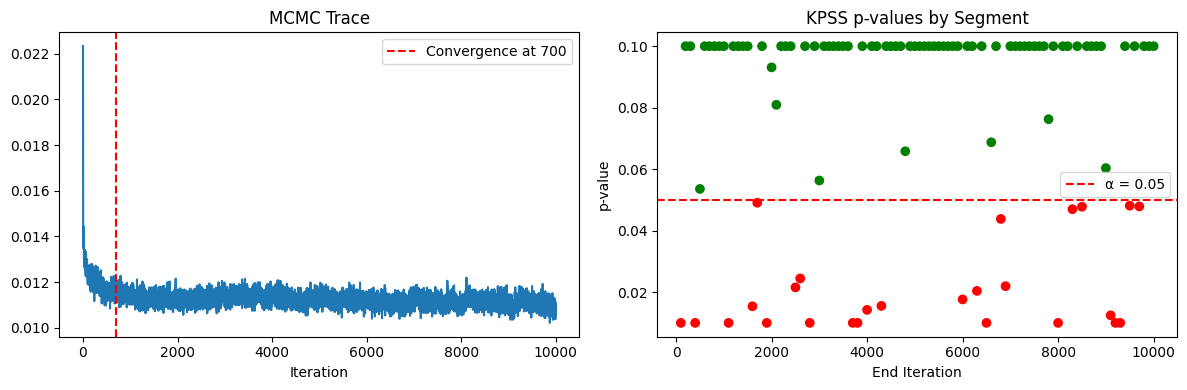

Chain converged: True
Convergence at iteration: 700
Convergence rate: 74.00%

RMSE convergence analysis:


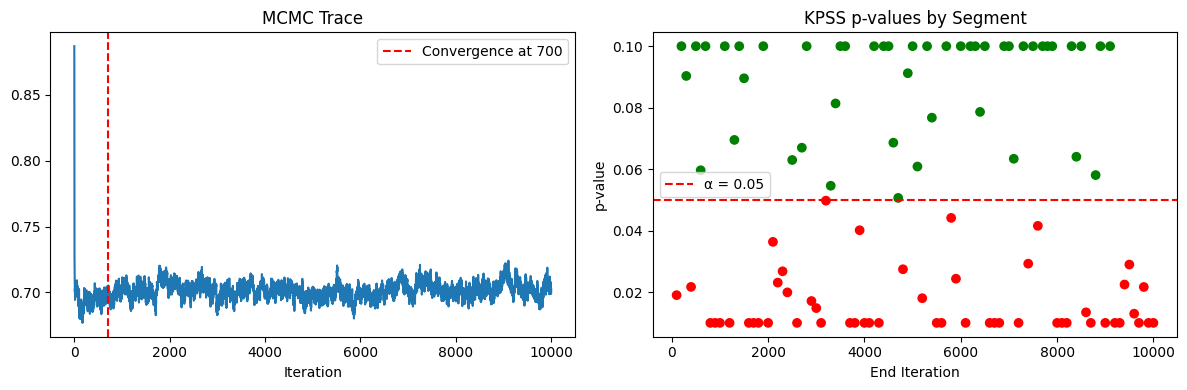

Chain converged: True
Convergence at iteration: 700
Convergence rate: 47.00%

--- Run 4 ---
Sigma convergence analysis:


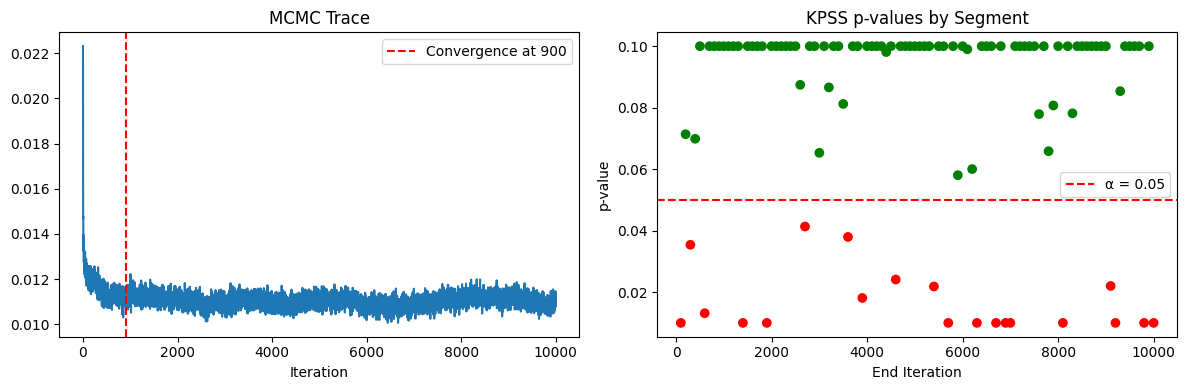

Chain converged: True
Convergence at iteration: 900
Convergence rate: 80.00%

RMSE convergence analysis:


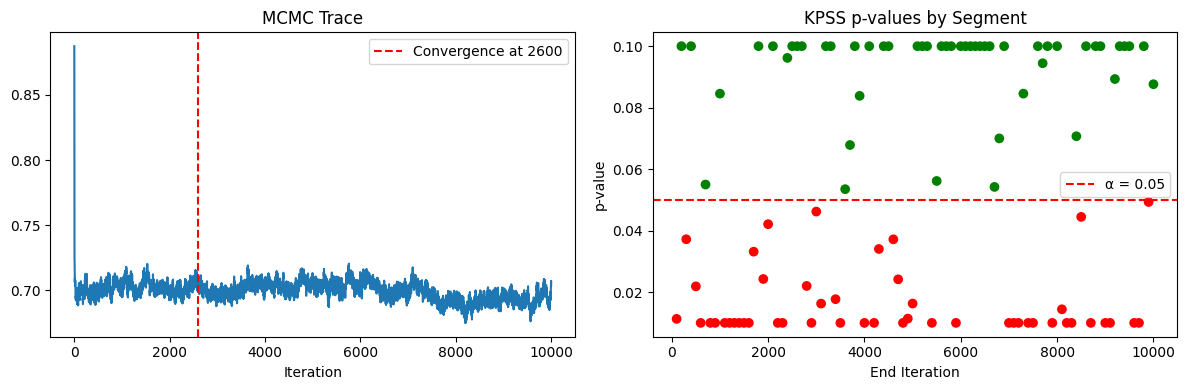

Chain converged: True
Convergence at iteration: 2600
Convergence rate: 51.00%


In [8]:
# Analyze each run's results and collect statistics
n_runs = 5

# Collect convergence statistics
default_sigma_convergence = []
default_rmse_convergence = []
default_sigma_rates = []
default_rmse_rates = []

# Analyze Default BART results
print("=== Default BART Analysis ===")
for run_id in range(n_runs):
    print(f"\n--- Run {run_id} ---")
    
    # Load sigmas and rmses for this run
    sigmas = np.load(f'store/{notebook}_sigmas_default_run{run_id}.npy')
    rmses = np.load(f'store/{notebook}_rmses_default_run{run_id}.npy')
    
    print(f"Sigma convergence analysis:")
    convergence_result = segmented_kpss_test(sigmas, segment_length=100)
    print(f"Chain converged: {convergence_result['converged']}")
    if convergence_result['converged']:
        print(f"Convergence at iteration: {convergence_result['convergence_iteration']}")
        default_sigma_convergence.append(convergence_result['convergence_iteration'])
    print(f"Convergence rate: {convergence_result['convergence_rate']:.2%}")
    default_sigma_rates.append(convergence_result['convergence_rate'])
    
    print(f"\nRMSE convergence analysis:")
    convergence_result = segmented_kpss_test(rmses, segment_length=100)
    print(f"Chain converged: {convergence_result['converged']}")
    if convergence_result['converged']:
        print(f"Convergence at iteration: {convergence_result['convergence_iteration']}")
        default_rmse_convergence.append(convergence_result['convergence_iteration'])
    print(f"Convergence rate: {convergence_result['convergence_rate']:.2%}")
    default_rmse_rates.append(convergence_result['convergence_rate'])

In [9]:
# Print summary statistics for Default BART
print("\n=== Default BART Summary ===")
if default_sigma_convergence:
    print(f"Sigma - Average convergence iteration: {np.mean(default_sigma_convergence):.0f}")
else:
    print("Sigma - No convergence detected")
print(f"Sigma - Average convergence rate: {np.mean(default_sigma_rates):.2%}")

if default_rmse_convergence:
    print(f"RMSE - Average convergence iteration: {np.mean(default_rmse_convergence):.0f}")
else:
    print("RMSE - No convergence detected")
print(f"RMSE - Average convergence rate: {np.mean(default_rmse_rates):.2%}")


=== Default BART Summary ===
Sigma - Average convergence iteration: 880
Sigma - Average convergence rate: 72.80%
RMSE - Average convergence iteration: 1500
RMSE - Average convergence rate: 50.20%


### ESS

In [10]:
# Add logging configuration before importing arviz
import logging
logging.getLogger('arviz.preview').setLevel(logging.WARNING)
import arviz as az

In [11]:
# Analyze each run's results
n_runs = 5

# Analyze Default BART results
print("=== Default BART Analysis ===")
for run_id in range(n_runs):
    print(f"\n--- Run {run_id} ---")
    
    # Load sigmas and rmses for this run
    sigmas = np.load(f'store/{notebook}_sigmas_default_run{run_id}.npy')
    rmses = np.load(f'store/{notebook}_rmses_default_run{run_id}.npy')

    print(f"Sigma ess value: {az.ess(sigmas[3000:].reshape(1, -1), relative=True).item():.6f}")
    print(f"RMSE ess value: {az.ess(rmses[3000:].reshape(1, -1), relative=True).item():.6f}")

=== Default BART Analysis ===

--- Run 0 ---
Sigma ess value: 0.001016
RMSE ess value: 0.002440

--- Run 1 ---
Sigma ess value: 0.001619
RMSE ess value: 0.003148

--- Run 2 ---
Sigma ess value: 0.000338
RMSE ess value: 0.001193

--- Run 3 ---
Sigma ess value: 0.001273
RMSE ess value: 0.001004

--- Run 4 ---
Sigma ess value: 0.005507
RMSE ess value: 0.000283


### Autocorrelation

In [12]:
from diagnosis import plot_autocorrelation

=== Default BART Analysis ===

--- Run 0 ---
Sigma autocorrelation plot:


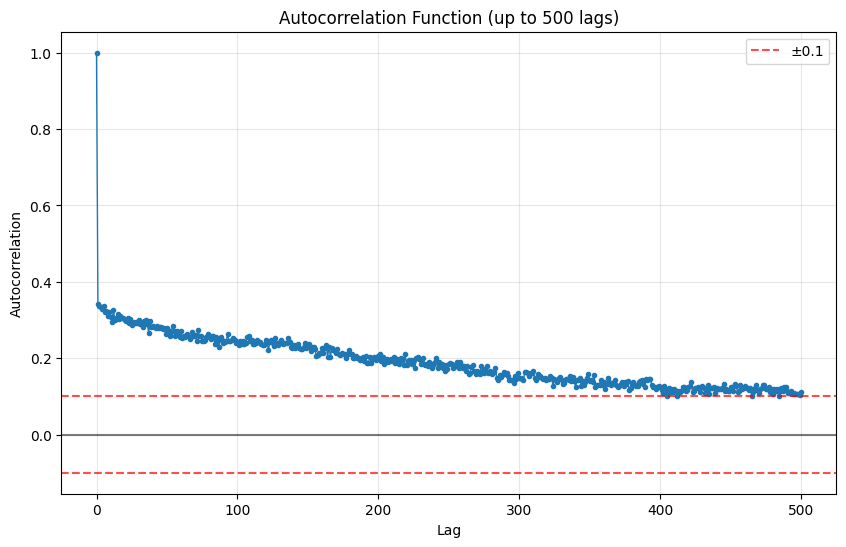

RMSE autocorrelation plot:


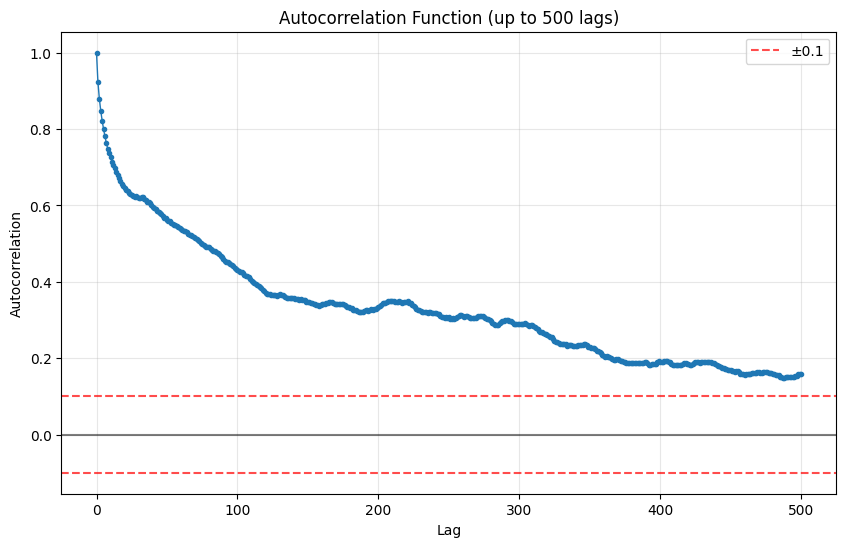


--- Run 1 ---
Sigma autocorrelation plot:


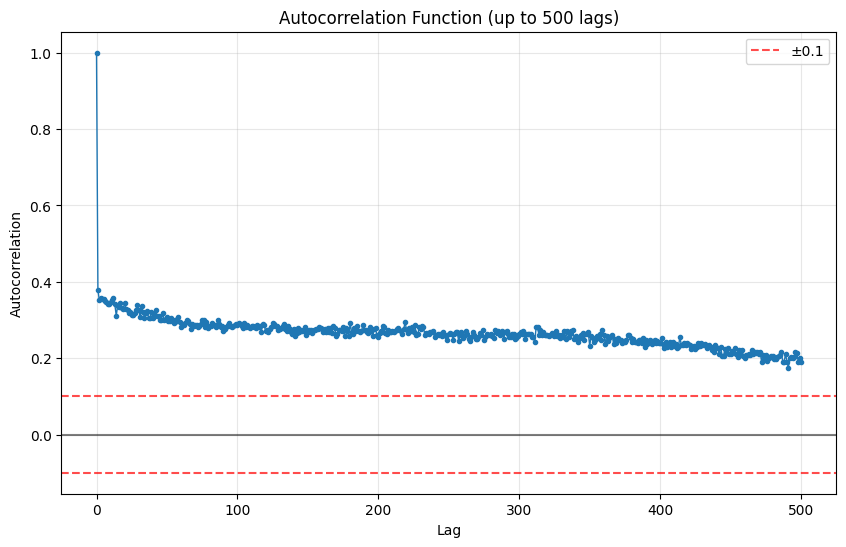

RMSE autocorrelation plot:


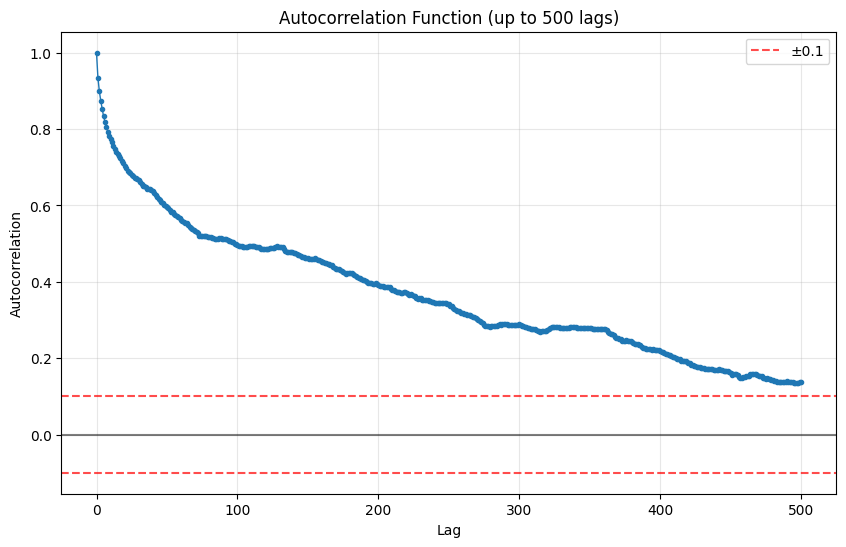


--- Run 2 ---
Sigma autocorrelation plot:


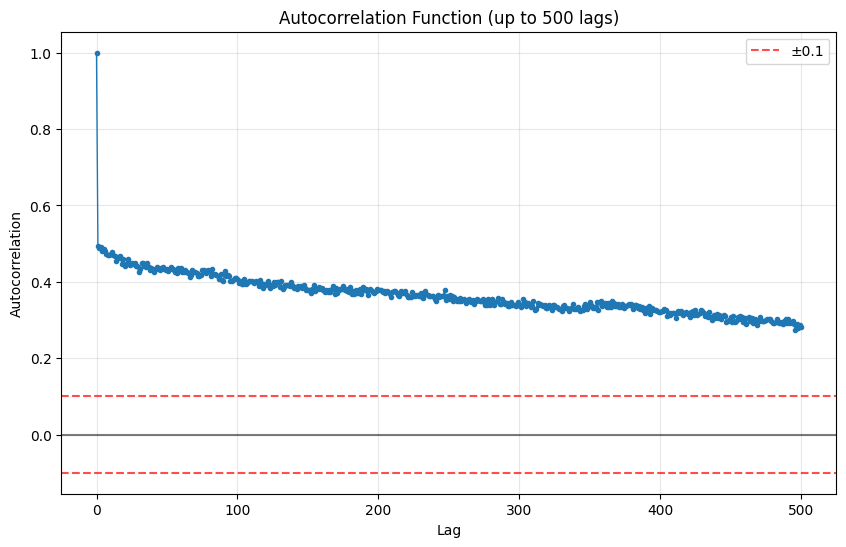

RMSE autocorrelation plot:


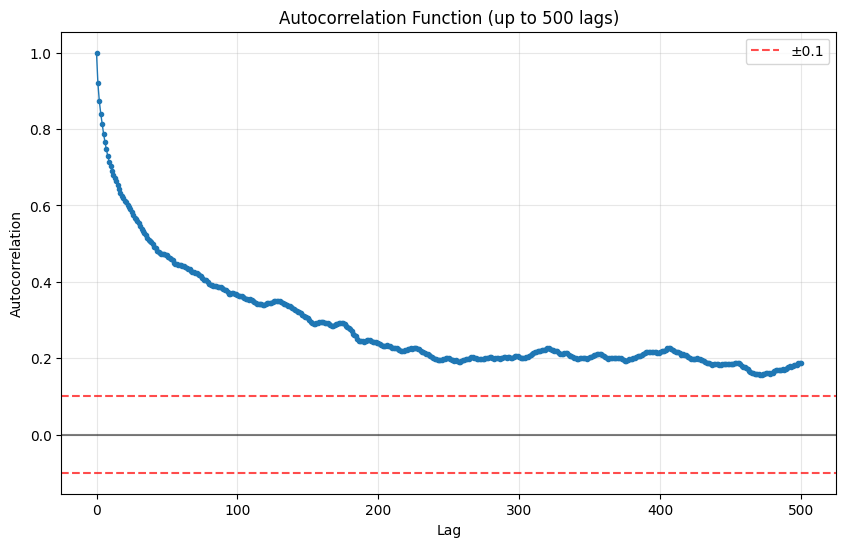


--- Run 3 ---
Sigma autocorrelation plot:


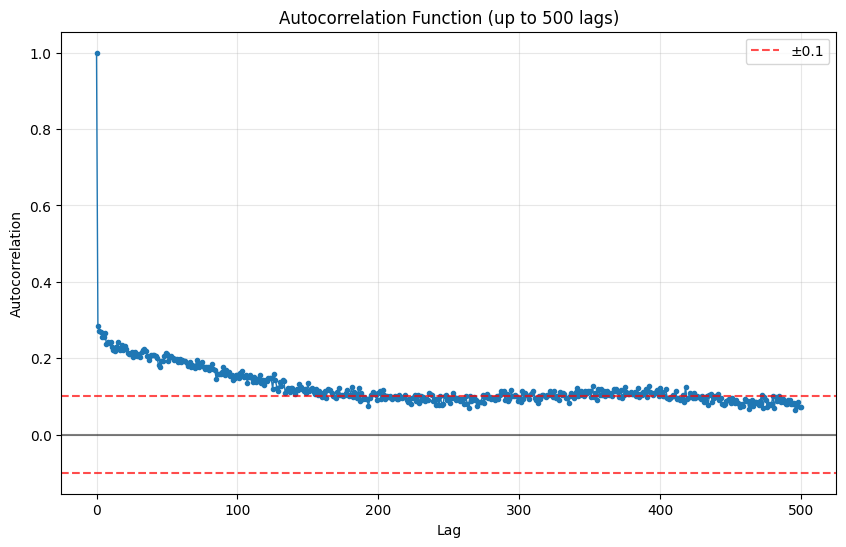

RMSE autocorrelation plot:


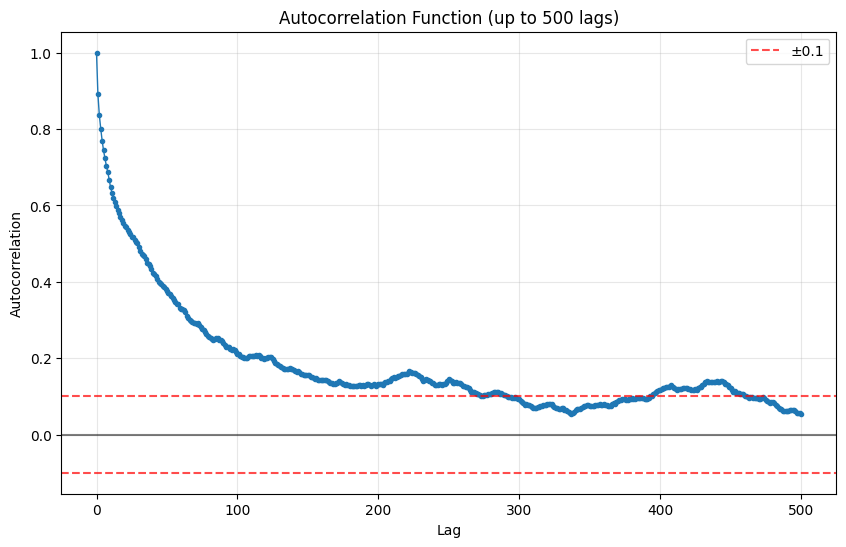


--- Run 4 ---
Sigma autocorrelation plot:


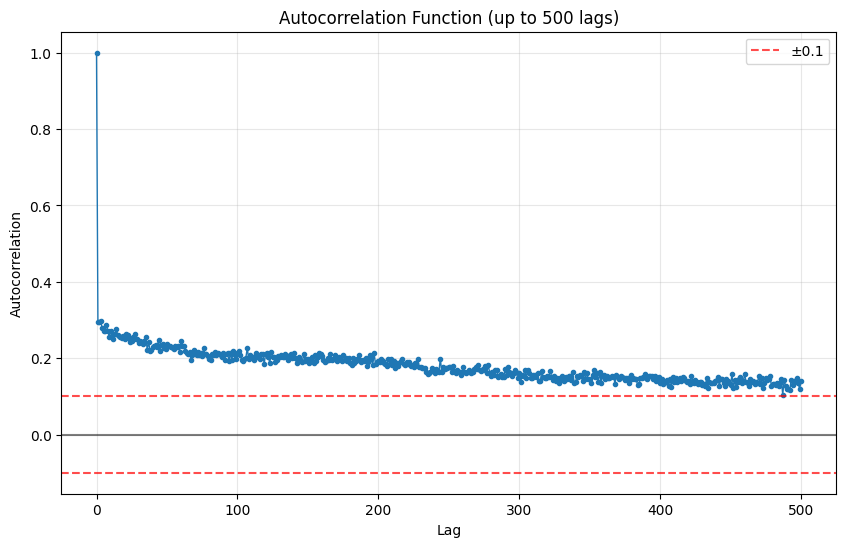

RMSE autocorrelation plot:


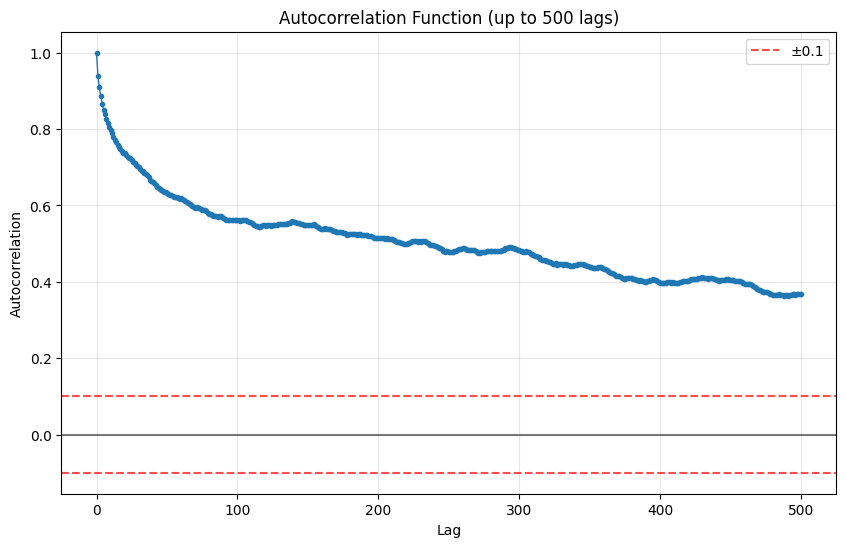

In [13]:
# Analyze each run's results
n_runs = 5

# Analyze Default BART results
print("=== Default BART Analysis ===")
for run_id in range(n_runs):
    print(f"\n--- Run {run_id} ---")
    
    # Load sigmas and rmses for this run
    sigmas = np.load(f'store/{notebook}_sigmas_default_run{run_id}.npy')
    rmses = np.load(f'store/{notebook}_rmses_default_run{run_id}.npy')

    print(f"Sigma autocorrelation plot:")
    plot_autocorrelation(sigmas[3000:], nlags=500)
    
    print(f"RMSE autocorrelation plot:")
    plot_autocorrelation(rmses[3000:], nlags=500)

## MTMH
### KPSS test

In [14]:
from diagnosis import segmented_kpss_test

=== MTMH BART Analysis ===

--- Run 0 ---
Sigma convergence analysis:


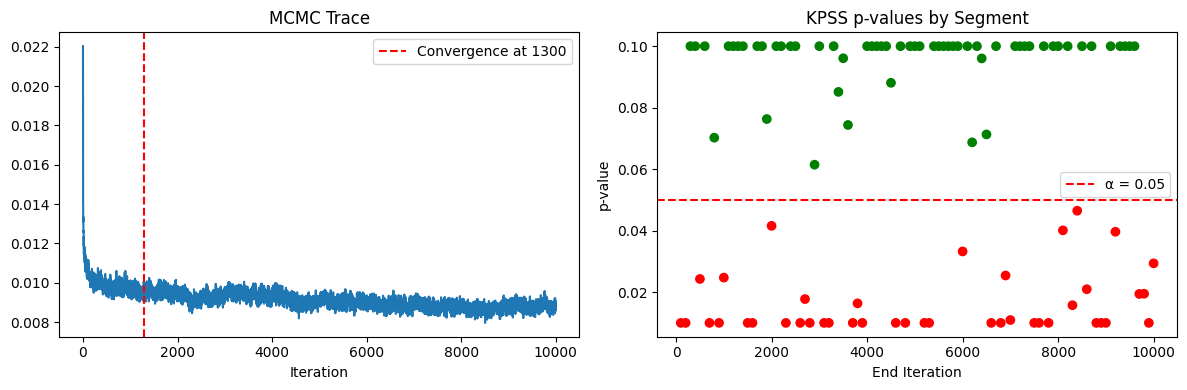

Chain converged: True
Convergence at iteration: 1300
Convergence rate: 58.00%

RMSE convergence analysis:


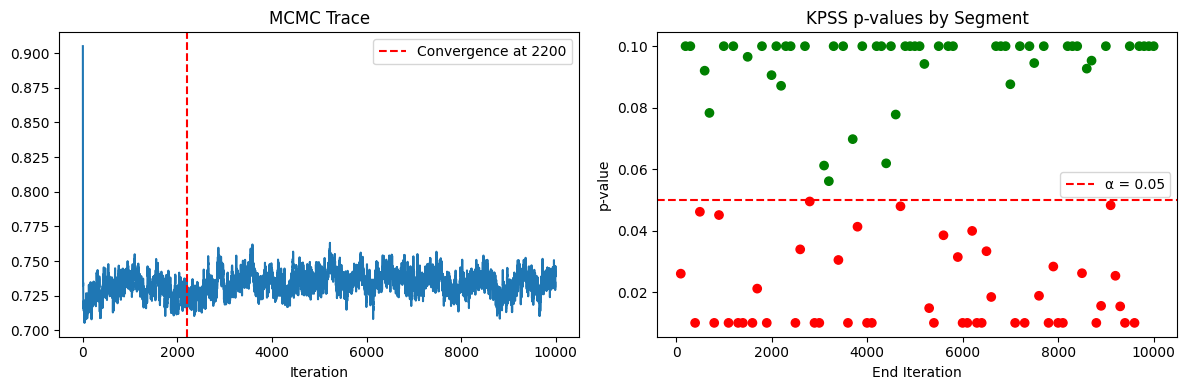

Chain converged: True
Convergence at iteration: 2200
Convergence rate: 52.00%

--- Run 1 ---
Sigma convergence analysis:


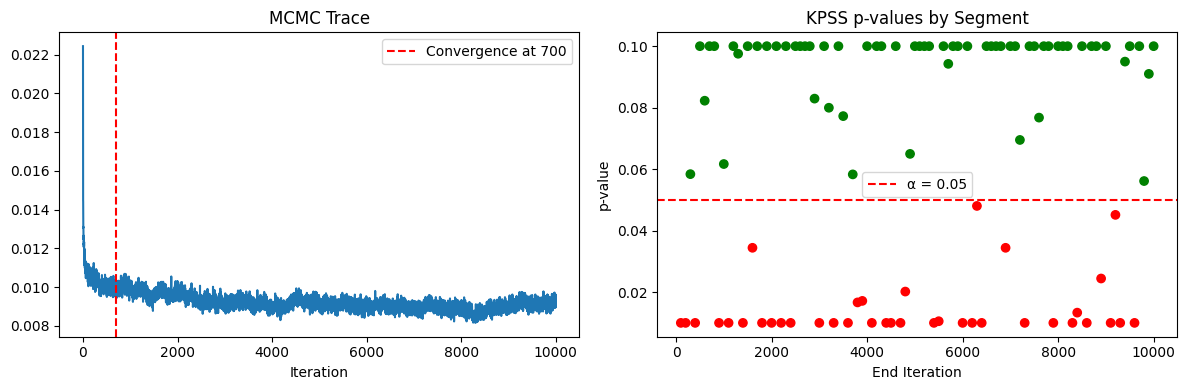

Chain converged: True
Convergence at iteration: 700
Convergence rate: 62.00%

RMSE convergence analysis:


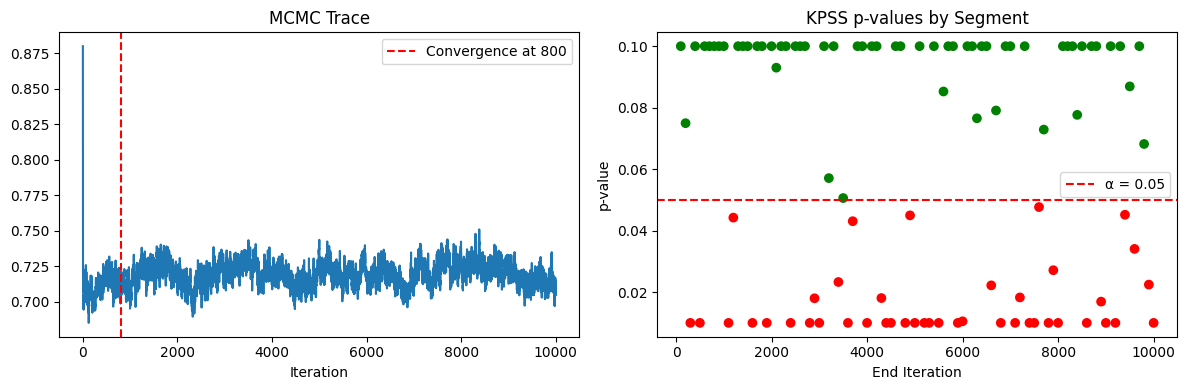

Chain converged: True
Convergence at iteration: 800
Convergence rate: 57.00%

--- Run 2 ---
Sigma convergence analysis:


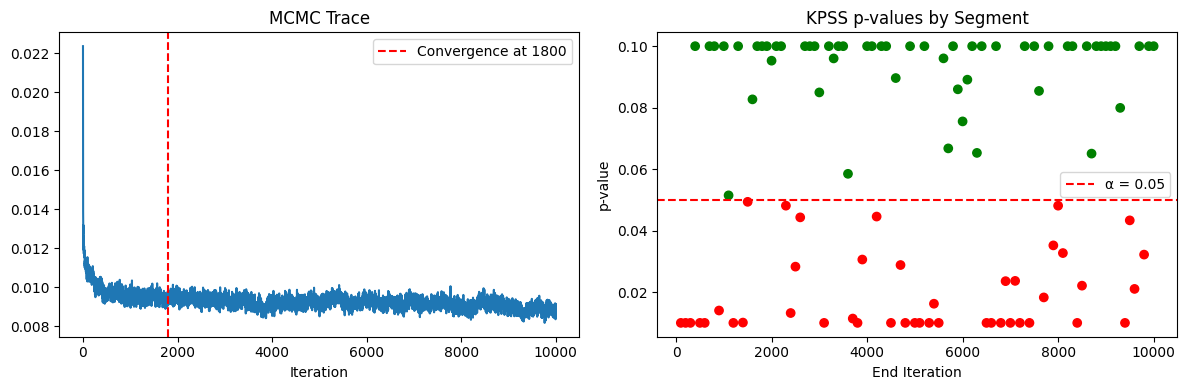

Chain converged: True
Convergence at iteration: 1800
Convergence rate: 56.00%

RMSE convergence analysis:


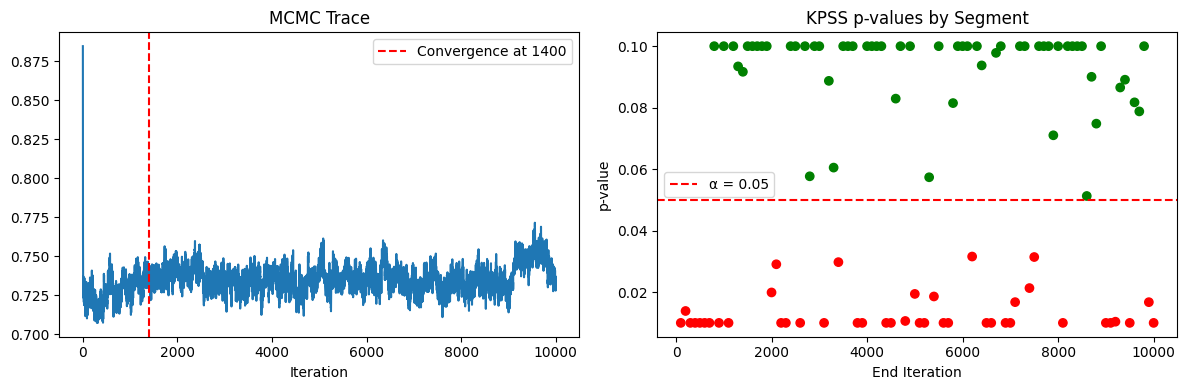

Chain converged: True
Convergence at iteration: 1400
Convergence rate: 58.00%

--- Run 3 ---
Sigma convergence analysis:


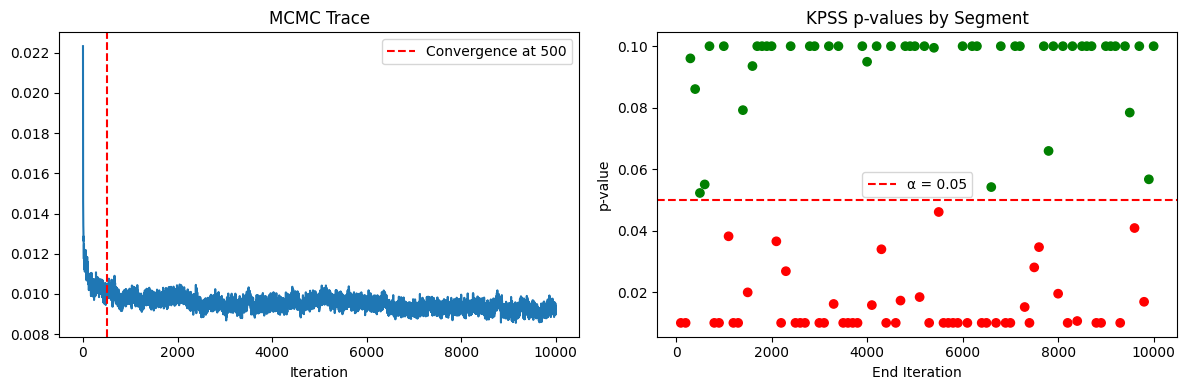

Chain converged: True
Convergence at iteration: 500
Convergence rate: 49.00%

RMSE convergence analysis:


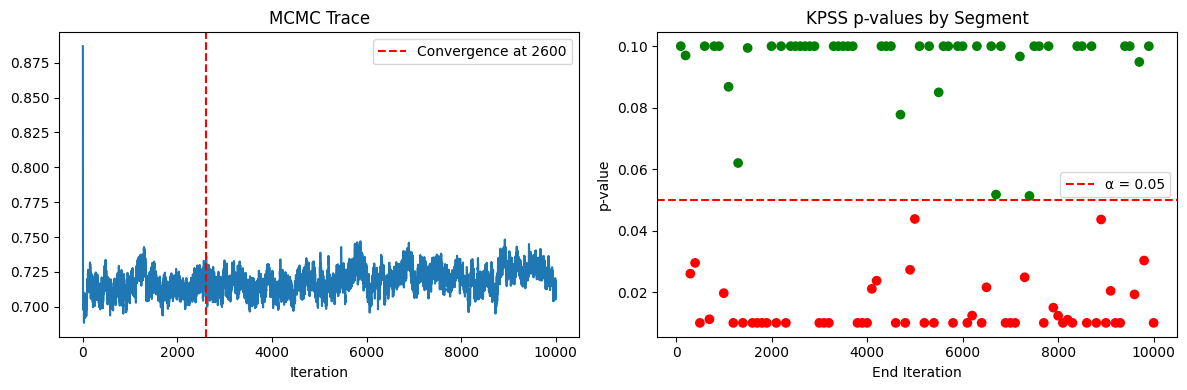

Chain converged: True
Convergence at iteration: 2600
Convergence rate: 48.00%

--- Run 4 ---
Sigma convergence analysis:


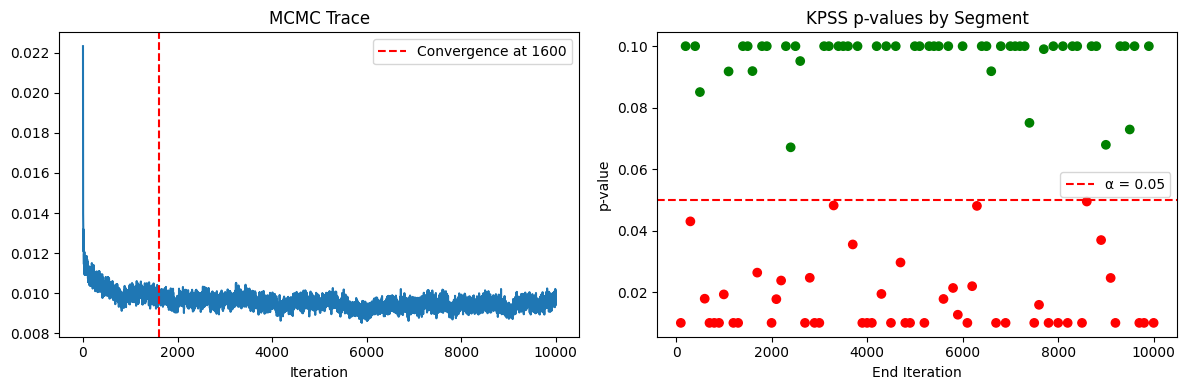

Chain converged: True
Convergence at iteration: 1600
Convergence rate: 51.00%

RMSE convergence analysis:


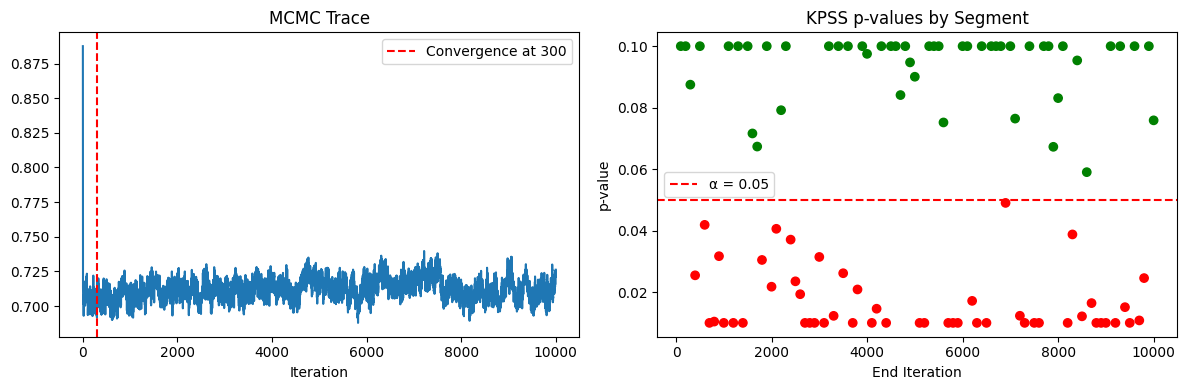

Chain converged: True
Convergence at iteration: 300
Convergence rate: 49.00%


In [15]:
# Analyze each run's results and collect statistics
n_runs = 5

# Collect convergence statistics
mtmh_sigma_convergence = []
mtmh_rmse_convergence = []
mtmh_sigma_rates = []
mtmh_rmse_rates = []

# Analyze MTMH BART results
print("=== MTMH BART Analysis ===")
for run_id in range(n_runs):
    print(f"\n--- Run {run_id} ---")
    
    # Load sigmas and rmses for this run
    sigmas = np.load(f'store/{notebook}_sigmas_mtmh_run{run_id}.npy')
    rmses = np.load(f'store/{notebook}_rmses_mtmh_run{run_id}.npy')

    print(f"Sigma convergence analysis:")
    convergence_result = segmented_kpss_test(sigmas, segment_length=100)
    print(f"Chain converged: {convergence_result['converged']}")
    if convergence_result['converged']:
        print(f"Convergence at iteration: {convergence_result['convergence_iteration']}")
        mtmh_sigma_convergence.append(convergence_result['convergence_iteration'])
    print(f"Convergence rate: {convergence_result['convergence_rate']:.2%}")
    mtmh_sigma_rates.append(convergence_result['convergence_rate'])

    print(f"\nRMSE convergence analysis:")
    convergence_result = segmented_kpss_test(rmses, segment_length=100)
    print(f"Chain converged: {convergence_result['converged']}")
    if convergence_result['converged']:
        print(f"Convergence at iteration: {convergence_result['convergence_iteration']}")
        mtmh_rmse_convergence.append(convergence_result['convergence_iteration'])
    print(f"Convergence rate: {convergence_result['convergence_rate']:.2%}")
    mtmh_rmse_rates.append(convergence_result['convergence_rate'])

In [16]:
# Print summary statistics for MTMH BART
print("\n=== MTMH BART Summary ===")
if mtmh_sigma_convergence:
    print(f"Sigma - Average convergence iteration: {np.mean(mtmh_sigma_convergence):.0f}")
else:
    print("Sigma - No convergence detected")
print(f"Sigma - Average convergence rate: {np.mean(mtmh_sigma_rates):.2%}")

if mtmh_rmse_convergence:
    print(f"RMSE - Average convergence iteration: {np.mean(mtmh_rmse_convergence):.0f}")
else:
    print("RMSE - No convergence detected")
print(f"RMSE - Average convergence rate: {np.mean(mtmh_rmse_rates):.2%}")


=== MTMH BART Summary ===
Sigma - Average convergence iteration: 1180
Sigma - Average convergence rate: 55.20%
RMSE - Average convergence iteration: 1460
RMSE - Average convergence rate: 52.80%


### ESS

In [17]:
# Add logging configuration before importing arviz
import logging
logging.getLogger('arviz.preview').setLevel(logging.WARNING)
import arviz as az

In [18]:
# Analyze each run's results
n_runs = 5

# Analyze MTMH BART results
print("=== MTMH BART Analysis ===")
for run_id in range(n_runs):
    print(f"\n--- Run {run_id} ---")
    
    # Load sigmas and rmses for this run
    sigmas = np.load(f'store/{notebook}_sigmas_mtmh_run{run_id}.npy')
    rmses = np.load(f'store/{notebook}_rmses_mtmh_run{run_id}.npy')

    print(f"Sigma ess value: {az.ess(sigmas[3000:].reshape(1, -1), relative=True).item():.6f}")
    print(f"RMSE ess value: {az.ess(rmses[3000:].reshape(1, -1), relative=True).item():.6f}")

=== MTMH BART Analysis ===

--- Run 0 ---
Sigma ess value: 0.000284
RMSE ess value: 0.010824

--- Run 1 ---
Sigma ess value: 0.001098
RMSE ess value: 0.005185

--- Run 2 ---
Sigma ess value: 0.000846
RMSE ess value: 0.004374

--- Run 3 ---
Sigma ess value: 0.000387
RMSE ess value: 0.000827

--- Run 4 ---
Sigma ess value: 0.006189
RMSE ess value: 0.007368


### Autocorrelation

In [19]:
from diagnosis import plot_autocorrelation

=== MTMH BART Analysis ===

--- Run 0 ---
Sigma autocorrelation plot:


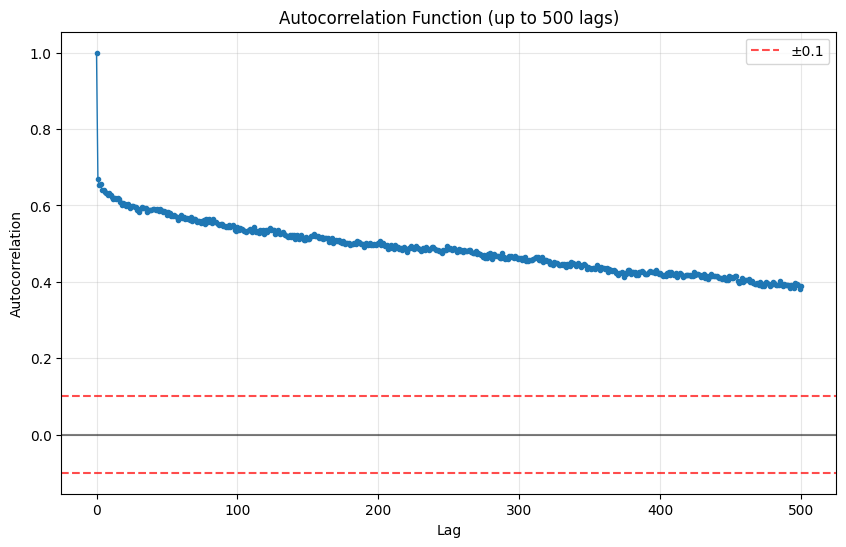

RMSE autocorrelation plot:


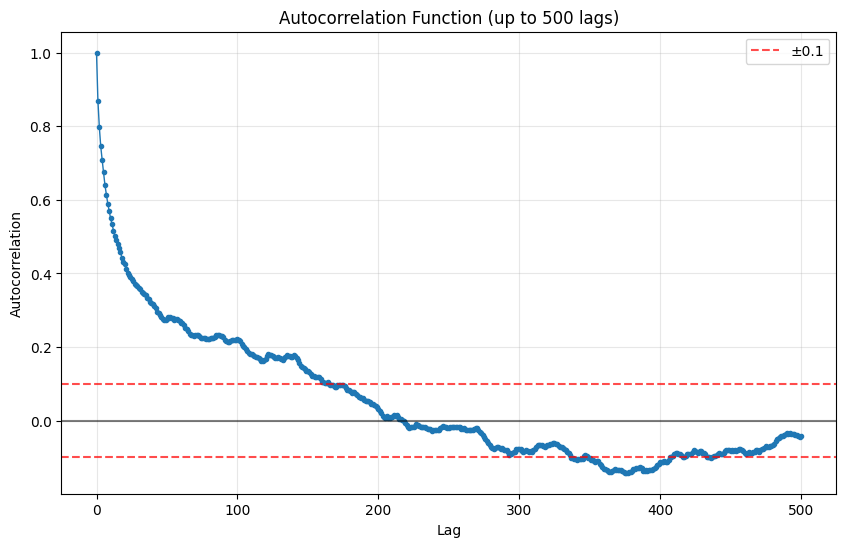


--- Run 1 ---
Sigma autocorrelation plot:


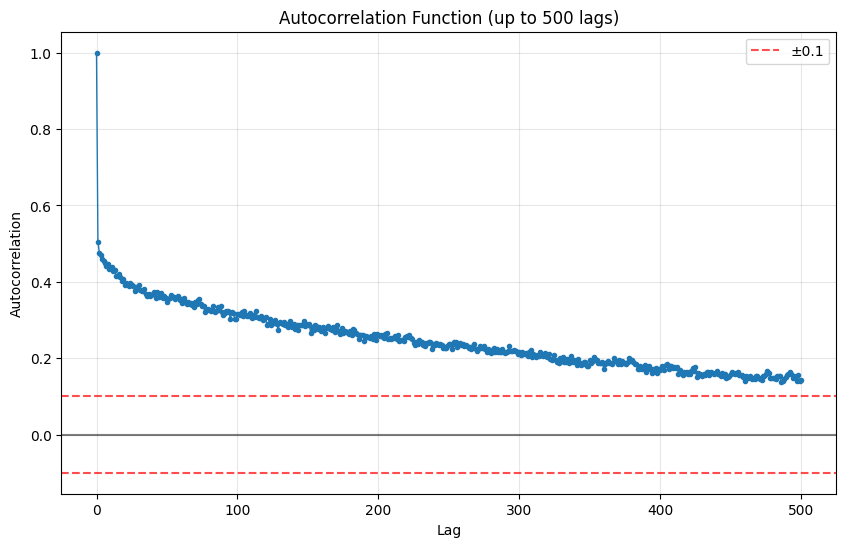

RMSE autocorrelation plot:


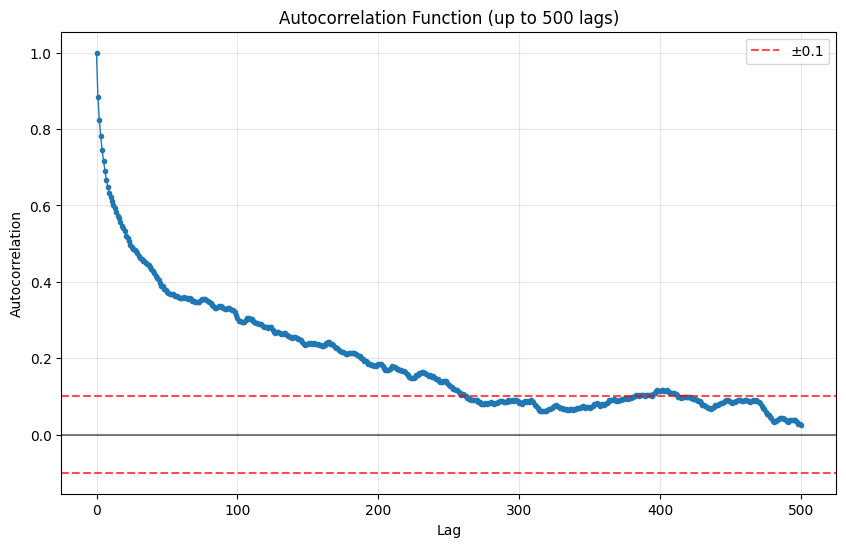


--- Run 2 ---
Sigma autocorrelation plot:


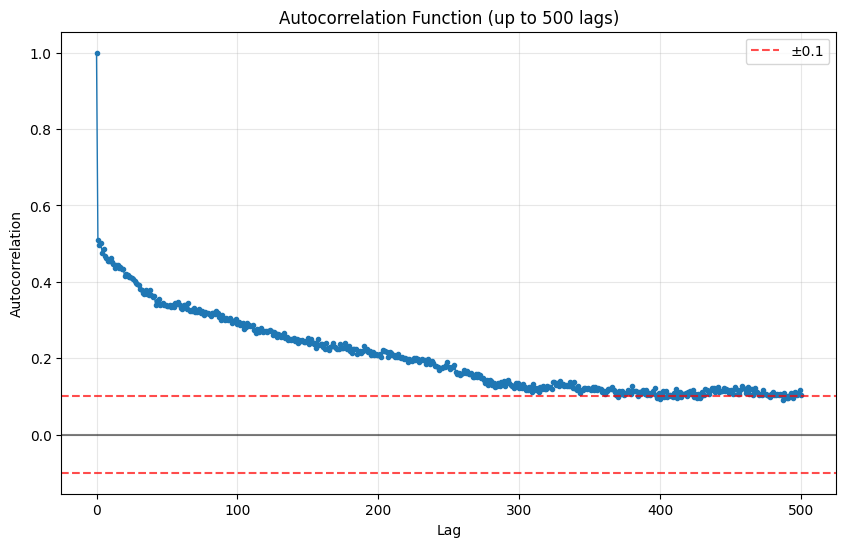

RMSE autocorrelation plot:


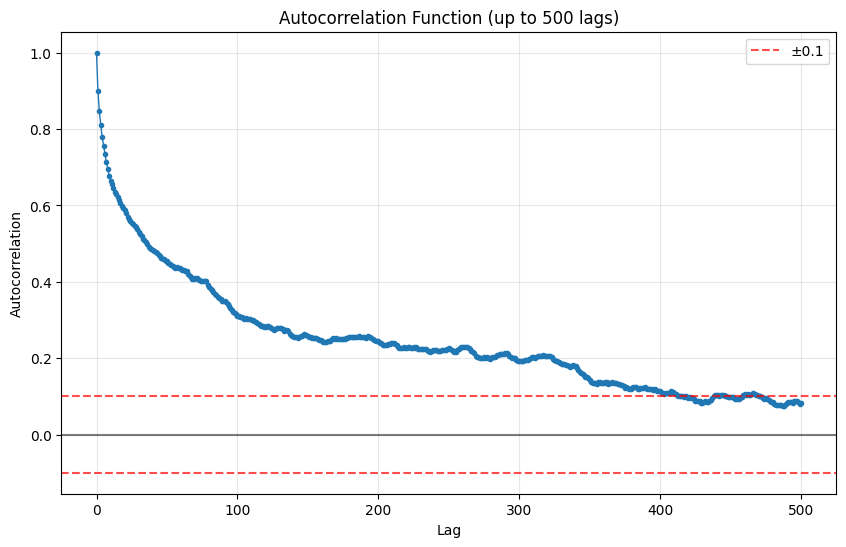


--- Run 3 ---
Sigma autocorrelation plot:


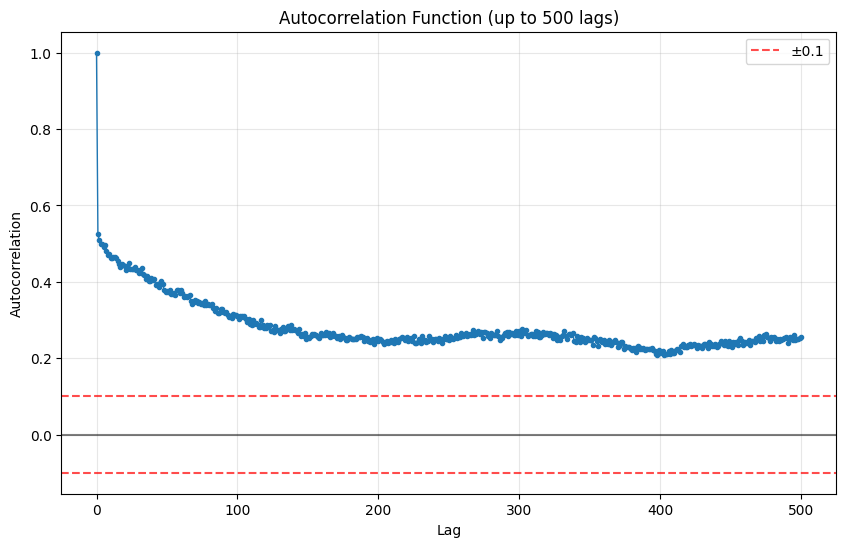

RMSE autocorrelation plot:


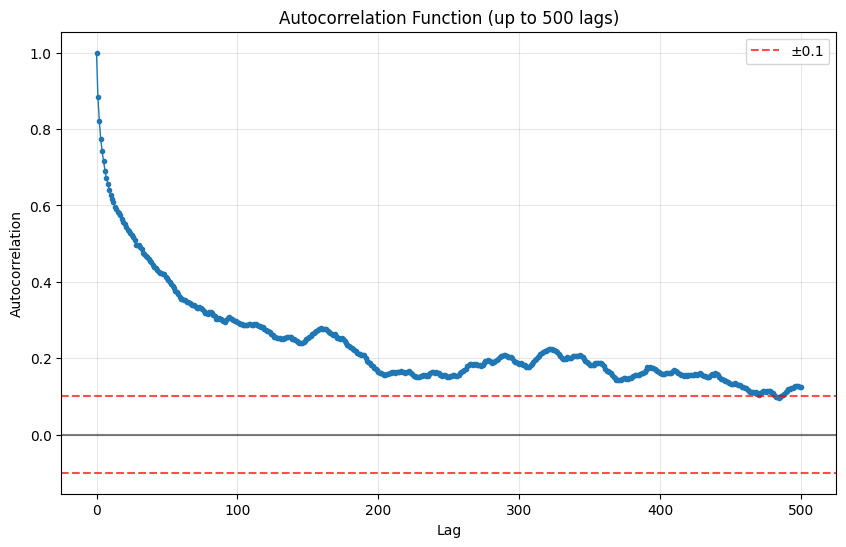


--- Run 4 ---
Sigma autocorrelation plot:


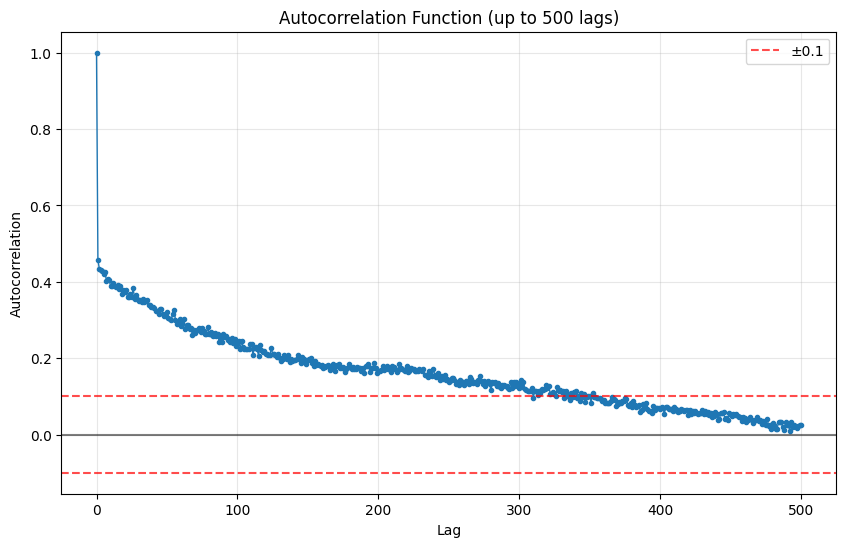

RMSE autocorrelation plot:


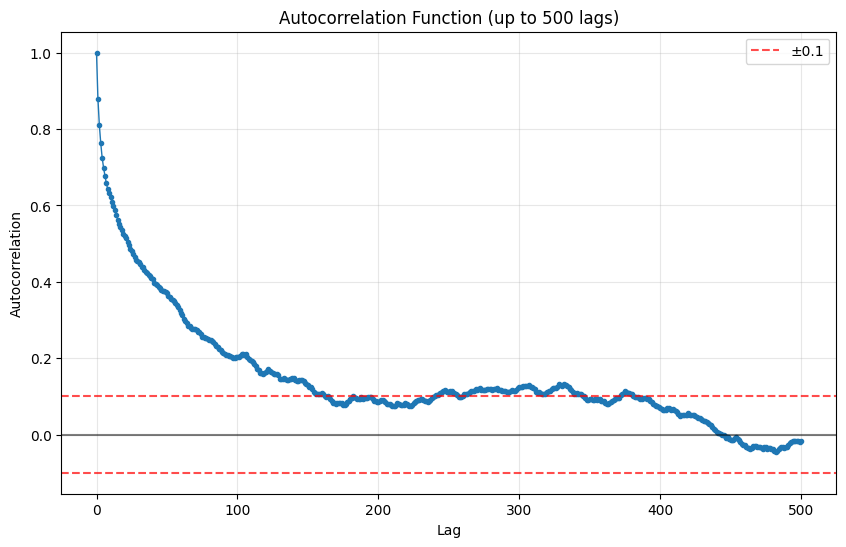

In [20]:
# Analyze each run's results
n_runs = 5

# Analyze MTMH BART results
print("=== MTMH BART Analysis ===")
for run_id in range(n_runs):
    print(f"\n--- Run {run_id} ---")
    
    # Load sigmas and rmses for this run
    sigmas = np.load(f'store/{notebook}_sigmas_mtmh_run{run_id}.npy')
    rmses = np.load(f'store/{notebook}_rmses_mtmh_run{run_id}.npy')

    print(f"Sigma autocorrelation plot:")
    plot_autocorrelation(sigmas[3000:], nlags=500)
    
    print(f"RMSE autocorrelation plot:")
    plot_autocorrelation(rmses[3000:], nlags=500)